In [16]:
!pip install phik scipy

Defaulting to user installation because normal site-packages is not writeable


In [31]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from PM_eq import penman_monteith

Tasks:

- [x] Add PM as an input features based on ERA5 time series;
- [x] Implement energy balance equation as a custom loss instead of PM: **Netrad - G = H + LE** (G - ground heat flux, H - sensible heat flux)
- [x] Double check PM equation implementation!;


----

#### Started **Transformer_v02** to try no ERA5 approach

# Data Processing and Analysis

In [32]:
era5 = np.load('./data/ERA5_features_MidWest.npy', allow_pickle=True)
era5_idxs = set(np.load('./data/ERA5_target_idx_MidWest.npy', allow_pickle=True))
mod = np.load('./data/MOD_features_MidWest.npy', allow_pickle=True)
mod_idxs = set(np.load('./data/MOD_target_idx_MidWest.npy', allow_pickle=True))

fluxes = pd.read_csv('./data/target_fluxes_MidWest_LE.csv')
keep_idxs = [idx for idx in fluxes.index.tolist() if (idx in era5_idxs) and (idx in mod_idxs)]
fluxes = fluxes.loc[keep_idxs,:]
fluxes['TIMESTAMP'] = pd.to_datetime(fluxes.TIMESTAMP, format='%Y%m%d')
targets = fluxes.LE_F_MDS.values

fluxes

FileNotFoundError: [Errno 2] No such file or directory: './data/ERA5_features_MidWest.npy'

### Energy Balance 

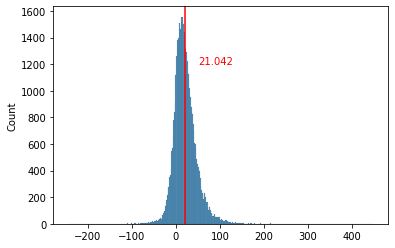

In [66]:
energy_balance = fluxes.NETRAD - fluxes.G_F_MDS - fluxes.H_F_MDS - fluxes.LE_F_MDS
sns.histplot(energy_balance)
plt.axvline(energy_balance.mean(), color='r')
plt.text(50, 1200, round(energy_balance.mean(), 3), color='r')
plt.savefig('./fig/energy_balance_flux.png')

### Feature-Feature Analysis

In [4]:
era5_idxs = pd.Series(list(era5_idxs))
era5_idxs.index = np.arange(len(era5_idxs))
valid_feature_indices = era5_idxs[era5_idxs.isin(fluxes.index)].index.values
era5_features = era5[valid_feature_indices]

mod_idxs = pd.Series(list(mod_idxs))
mod_idxs.index = np.arange(len(mod_idxs))
valid_feature_indices = mod_idxs[mod_idxs.isin(fluxes.index)].index.values
mod_features = mod[valid_feature_indices]
mod_features = mod_features[:,:,:-1]#Dropping Coarse_Resolution_Internal_CM

NDVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0])
EVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + 6*mod_features[:,:,0] - 7.5*mod_features[:,:,2] + 1)
GNDVI = (mod_features[:,:,1] - mod_features[:,:,3])/(mod_features[:,:,1] + mod_features[:,:,3])
SAVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0] + 0.5)*1.5
ARVI = (mod_features[:,:,1] + mod_features[:,:,2] - 2*mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,2] + 2*mod_features[:,:,0])

pm_era = penman_monteith(era5_features, fluxes.index, fluxes, mode='era5')

features = np.concatenate([era5_features, mod_features, pm_era[:,:, np.newaxis], 
                           NDVI[:,:, np.newaxis], EVI[:,:, np.newaxis], GNDVI[:,:, np.newaxis],
                           SAVI[:,:, np.newaxis], ARVI[:,:, np.newaxis]], axis=2)

era_names = list(np.loadtxt('./data/ERA5_features_names_MidWest.txt', dtype=str))
mod_names = [
          'Coarse_Resolution_Surface_Reflectance_Band_1', 'Coarse_Resolution_Surface_Reflectance_Band_2',
           'Coarse_Resolution_Surface_Reflectance_Band_3', 'Coarse_Resolution_Surface_Reflectance_Band_4', 
           'Coarse_Resolution_Solar_Zenith_Angle', 
          'Coarse_Resolution_Ozone', 'Coarse_Resolution_Brightness_Temperature_Band_20',
          'Coarse_Resolution_Brightness_Temperature_Band_21', 'Coarse_Resolution_Brightness_Temperature_Band_31',
          'Coarse_Resolution_Brightness_Temperature_Band_32', 
]

In [5]:
era_df = pd.DataFrame(data=era5_features[:,-1,:], columns=era_names)

era_df['wind'] = np.sqrt(era_df.u_component_of_wind_10m**2 + era_df.v_component_of_wind_10m**2)
era_df['surface_net_solar_radiation_sum'] /= (60*60*24)
era_df['temperature_2m'] -= 273.15
era_df['source'] = ['ERA5']*len(era_df)
era_df = era_df[['surface_net_solar_radiation_sum', 'surface_pressure', 'temperature_2m', 'wind', 'source']]
era_df.columns = ['NetRad', 'Pressure', '2m_temp', 'Wind', 'Data_Source']

fluxes_scaled = fluxes.copy()
fluxes_scaled['PA_F'] *= 1000
fluxes_scaled['source'] = ['Ground']*len(fluxes_scaled)
fluxes_scaled = fluxes_scaled[['NETRAD', 'TA_F', 'WS_F', 'PA_F', 'source']]
fluxes_scaled.columns = ['NetRad', '2m_temp', 'Wind', 'Pressure', 'Data_Source']

era_vs_fluxes = pd.concat([era_df, fluxes_scaled], axis=0)
era_vs_fluxes

,NetRad,Pressure,2m_temp,Wind,Data_Source
0,321.450741,100106.198568,4.918890,2.845652,ERA5
1,326.032963,99678.292806,6.571551,2.436569,ERA5
2,308.156042,99590.606283,8.440127,1.171796,ERA5
3,329.122269,99792.442220,10.633368,0.892529,ERA5
4,328.390833,99632.253418,12.619012,0.553160,ERA5
...,...,...,...,...,...
69980,53.168840,98375.000000,18.619000,3.292000,Ground
69981,59.112736,98598.000000,11.036000,3.705000,Ground
69982,129.868352,98678.000000,11.989000,4.747000,Ground
69983,130.866277,98673.000000,13.565000,1.686000,Ground


In [7]:
colors = ['brown', 'darkcyan']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

<Figure size 864x864 with 0 Axes>

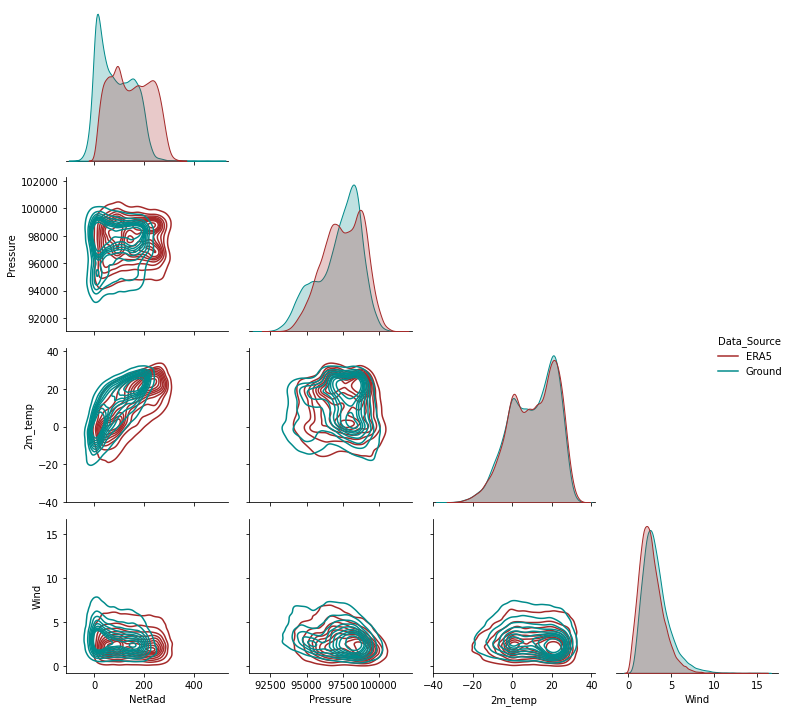

In [83]:
plt.figure(figsize=(12, 12))
sns.pairplot(era_vs_fluxes, hue='Data_Source', corner=True, 
             palette=['brown', 'darkcyan'], kind="kde")
plt.tight_layout()
plt.savefig('./fig/pairplots.png')
plt.show()

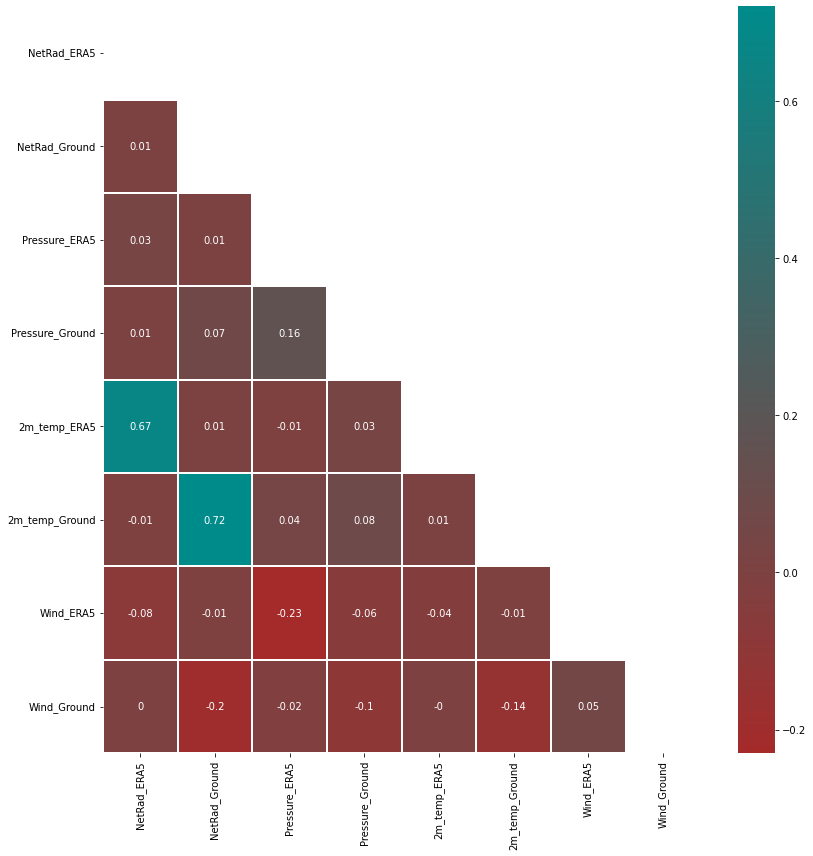

In [117]:
pivot_df = era_vs_fluxes.pivot(columns='Data_Source')
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df = pivot_df.dropna()
corr_matrix = pivot_df.corr()
mask = np.triu(corr_matrix, k=0).astype(bool)

figure, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(round(corr_matrix,2), cmap=custom_cmap, annot=True, linewidths=0.25, mask=mask, ax=ax)
plt.tight_layout()
plt.savefig('./fig/features_heatmap.png')
plt.show()

### Feature-Target Analysis

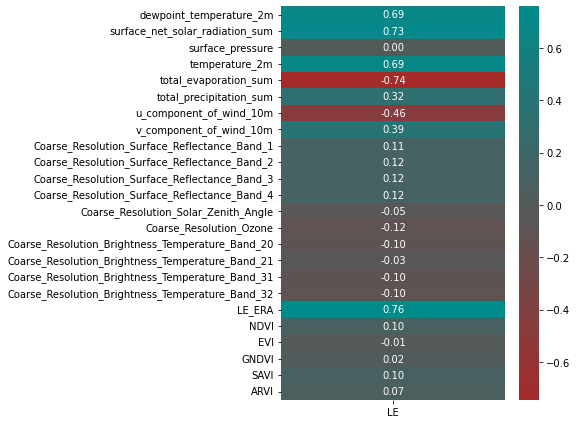

In [14]:
df = pd.DataFrame(data=features.mean(axis=(1)), columns=era_names+mod_names+['LE_ERA', 'NDVI', 'EVI', "GNDVI", 'SAVI', 'ARVI'])
df['LE'] = fluxes.LE_F_MDS.values
# df['LE_ERA'] /= 10
correlation_matrix = df.corr()[["LE"]].iloc[:-1]

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, cbar=True, fmt=".2f")
plt.tight_layout()
plt.savefig('./fig/targets_heatmap.png')
plt.show()

interval columns not set, guessing: ['dewpoint_temperature_2m', 'surface_net_solar_radiation_sum', 'surface_pressure', 'temperature_2m', 'total_evaporation_sum', 'total_precipitation_sum', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'Coarse_Resolution_Surface_Reflectance_Band_1', 'Coarse_Resolution_Surface_Reflectance_Band_2', 'Coarse_Resolution_Surface_Reflectance_Band_3', 'Coarse_Resolution_Surface_Reflectance_Band_4', 'Coarse_Resolution_Solar_Zenith_Angle', 'Coarse_Resolution_Ozone', 'Coarse_Resolution_Brightness_Temperature_Band_20', 'Coarse_Resolution_Brightness_Temperature_Band_21', 'Coarse_Resolution_Brightness_Temperature_Band_31', 'Coarse_Resolution_Brightness_Temperature_Band_32', 'LE_ERA', 'NDVI', 'EVI', 'GNDVI', 'SAVI', 'ARVI', 'LE']


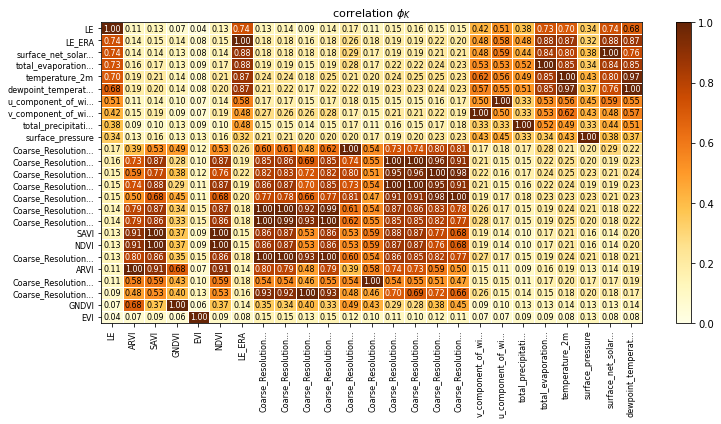

In [22]:
phik_overview = df.phik_matrix().round(2).sort_values('LE')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="YlOrBr",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [16]:
LE_PM = penman_monteith(features, fluxes.index, fluxes, mode='ground')
fluxes_exp = fluxes.copy()
fluxes_exp['LE_PM'] = LE_PM
fluxes_exp

,TIMESTAMP,LE_F_MDS,LE_F_MDS_QC,NETRAD,G_F_MDS,TA_F,VPD_F,WS_F,PA_F,site,H_F_MDS,lat,lon,IGBP,LE_PM
0,2003-05-24,19.2224,1.000000,236.108854,-1.567770,11.213,10.345,1.841,98.421,FLX_US-Wi1,138.4700,46.7305,-91.2329,DBF,1149.177229
1,2003-05-25,24.2024,1.000000,227.120214,-1.126670,12.308,10.551,1.835,98.471,FLX_US-Wi1,112.4050,46.7305,-91.2329,DBF,1145.318877
2,2003-05-26,19.4017,0.937500,249.112486,0.019932,14.778,12.203,1.660,98.656,FLX_US-Wi1,108.9370,46.7305,-91.2329,DBF,1366.408950
3,2003-05-27,23.7468,1.000000,244.104535,1.914990,18.154,15.802,1.532,98.265,FLX_US-Wi1,112.9390,46.7305,-91.2329,DBF,1486.394503
4,2003-05-28,42.2603,0.937500,246.821474,0.114018,14.890,6.921,2.285,97.722,FLX_US-Wi1,85.0435,46.7305,-91.2329,DBF,1257.312235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69980,2017-04-20,24.4564,0.916667,53.168840,2.570500,18.619,8.198,3.292,98.375,AMF_US-Mo3,43.3573,39.2322,-92.1493,CRO,315.044497
69981,2017-04-21,20.0859,1.000000,59.112736,-12.904500,11.036,5.241,3.705,98.598,AMF_US-Mo3,41.5803,39.2322,-92.1493,CRO,316.940850
69982,2017-04-22,23.8770,1.000000,129.868352,-2.438640,11.989,7.787,4.747,98.678,AMF_US-Mo3,89.7957,39.2322,-92.1493,CRO,543.957234
69983,2017-04-23,22.2580,1.000000,130.866277,5.497610,13.565,10.966,1.686,98.673,AMF_US-Mo3,81.1676,39.2322,-92.1493,CRO,689.540109


interval columns not set, guessing: ['LE_F_MDS', 'LE_F_MDS_QC', 'NETRAD', 'G_F_MDS', 'TA_F', 'VPD_F', 'WS_F', 'PA_F', 'H_F_MDS', 'lat', 'lon', 'LE_PM']


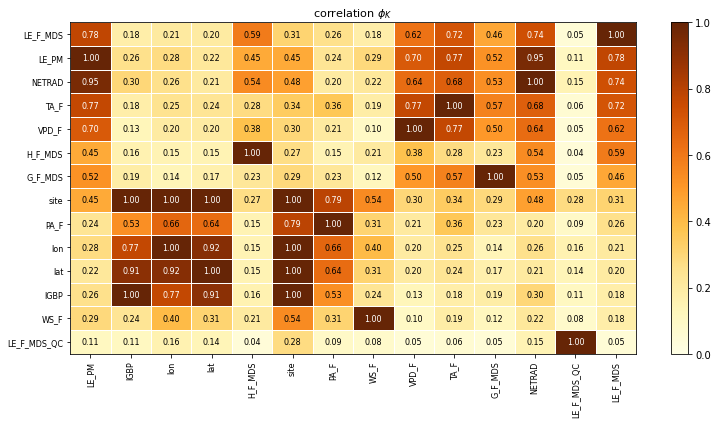

In [21]:
phik_overview = fluxes_exp.loc[:,'LE_F_MDS':].phik_matrix().round(2).sort_values('LE_F_MDS')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="YlOrBr",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

# Torch Classes

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(30)) / d_model)) #decaying freq
        pe[:, 0::2] = torch.sin(position * div_term) #even
        pe[:, 1::2] = torch.cos(position * div_term) #odd
        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

In [24]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super().__init__()
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=4*model_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.regressor = nn.Linear(model_dim, 128)
        self.regressor2 = nn.Linear(128, 1)
        self.activation = nn.ReLU()
        self.norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(self.norm(x))
        x = x.permute(0, 2, 1)  # Swap to (B, C, T) for pooling

        x = self.pooling(x).squeeze(-1)  # Pool across time
        x = self.regressor(x)
        x = self.regressor2(self.activation(x))  # Output single ET value
        return x

In [25]:
class CustomDataset(Dataset):
    def __init__(self, X, y, x_scaler=None, y_scaler=None, fit_scalers=False):
        self.x_scaler = x_scaler if x_scaler else MinMaxScaler()
        self.y_scaler = y_scaler if y_scaler else MinMaxScaler()

        if fit_scalers: 
            print('fitting')
            N, T, F = X.shape
            X_reshaped = X.reshape(N, -1)  # Flatten time/feature dims
            self.x_scaler.fit(X_reshaped)
            self.y_scaler.fit(y)

        # Transform data
        N, T, F = X.shape
        X_scaled = self.x_scaler.transform(X.reshape(N, -1)).reshape(N, T, F)
        y_scaled = self.y_scaler.transform(y.reset_index().to_numpy()[:,1].reshape(-1, 1))
        
        self.X = torch.tensor(X_scaled, dtype=torch.float32)
        self.y = torch.tensor(y_scaled, dtype=torch.float32)
        self.target_idx = torch.tensor(y.reset_index().to_numpy()[:,0].reshape(-1, 1), dtype=torch.int32)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.target_idx[idx]

In [26]:
def energy_balance(LE_pred, target_idx, mode='ground'):
    #Netrad - G = H + LE
    target_idx = target_idx.flatten().numpy()
    Netrad = torch.tensor(fluxes.loc[target_idx, 'NETRAD'].values, dtype=torch.float32).to(device)
    G = torch.tensor(fluxes.loc[target_idx, 'G_F_MDS'].values, dtype=torch.float32).to(device)
    H = torch.tensor(fluxes.loc[target_idx, 'H_F_MDS'].values, dtype=torch.float32).to(device)
    disclosure = Netrad - G - H - LE_pred
    return disclosure

class Custom_Loss(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha  

    def forward(self, predictions, targets, pm_inputs, target_idx):
        predictions = self.revers_scaling(predictions, train_dataset.y_scaler)
        targets = self.revers_scaling(targets, train_dataset.y_scaler)
        
        mse_loss = self.mse(predictions, targets).type(torch.float32)
        disclosure = energy_balance(predictions, target_idx).type(torch.float32)
        
        balance_loss = self.mse(predictions, disclosure).type(torch.float32) 
        total_loss = mse_loss + self.alpha * balance_loss
        return total_loss
    
    def revers_scaling(self, tensor, scaler): #to avoid detachment and losing grads
        data_min = torch.tensor(scaler.data_min_, device="cuda", dtype=torch.float32)
        data_max = torch.tensor(scaler.data_max_, device="cuda", dtype=torch.float32)
        return tensor * (data_max - data_min) + data_min 

# Training

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, fluxes, test_size=0.3, random_state=42)

y_train = y_train.LE_F_MDS#reshape(-1, 1)
y_test = y_test.LE_F_MDS#reshape(-1, 1)

x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
N, T, F = X_train.shape
x_scaler.fit(X_train.reshape(N, -1))
y_scaler.fit(y_train.reset_index().to_numpy()[:,1].reshape(-1, 1))

train_dataset = CustomDataset(X_train, y_train, x_scaler, y_scaler, fit_scalers=False)
test_dataset = CustomDataset(X_test, y_test, x_scaler, y_scaler, fit_scalers=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epoch = 150

input_dim = 24 #num features
model_dim = 1000
num_heads = 250
num_layers = 8 #8
dropout=0.3

In [32]:
model = TransformerEncoder(input_dim, model_dim, num_heads, num_layers, dropout).to(device)
#model.load_state_dict(torch.load(f'./models/transformer_state_{num_layers}_{num_heads}_{model_dim}.pth', weights_only=True))

In [33]:
print(f'The number of model params: {sum(p.numel() for p in model.parameters())}')

The number of model params: 96259257


In [35]:
criteria = Custom_Loss(alpha=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4) #4
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=0)

In [36]:
best = -np.inf
t0 = time.time()
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, y, idx in train_loader:
        x, y = x.to(device), y.squeeze().to(device)
        pred = model(x).squeeze()
        error = criteria(pred, y.to(device), x.to(device), idx)

        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        scheduler.step()
    if epoch % 5 == 0:
        model.eval()
        test_preds = []
        test_true = []
        test_x = []
        test_idx = []
        with torch.no_grad():
            for x, y, idx in test_loader:
                x, y = x.to(device), y.squeeze().to(device)
                preds = model(x).squeeze()
                test_preds.append(preds.detach().cpu())
                test_true.append(y.detach().cpu())
                test_x.append(x.detach().cpu())
                test_idx.append(idx)
        test_preds = torch.cat(test_preds).squeeze()
        test_true = torch.cat(test_true).squeeze()
        test_x = torch.cat(test_x).squeeze()
        test_idx = torch.cat(test_idx).squeeze()
        
        test_loss = criteria(test_preds.to(device), test_true.to(device), test_x.to(device), test_idx).item()
        r2 = r2_score(test_true.detach().cpu().numpy(), test_preds.detach().cpu().numpy())

        best_old = best
        best = min(test_loss, best)
        if abs(best) > best_old:
          torch.save(model.state_dict(), f'./models/transformer_state_{num_layers}_{num_heads}_{model_dim}.pth') #0.6532
        print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t{round((time.time()-t0)/60,3)} min')

Test RMSE: 46.221		Test R2: -0.0098		1.244 min
Test RMSE: 31.121		Test R2: 0.5983		6.847 min
Test RMSE: 29.703		Test R2: 0.6330		12.554 min
Test RMSE: 29.106		Test R2: 0.6201		18.327 min
Test RMSE: 28.891		Test R2: 0.6391		24.134 min
Test RMSE: 28.707		Test R2: 0.6409		29.96 min
Test RMSE: 28.651		Test R2: 0.6390		35.786 min
Test RMSE: 29.141		Test R2: 0.6411		41.619 min
Test RMSE: 49.514		Test R2: -0.0753		47.444 min



KeyboardInterrupt: 

# Logs

5 epochs - 0.64